# Reconstruction of TOF Vision 600

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import sirf.STIR as STIR
import scipy.ndimage as ndi
STIR.AcquisitionData.set_storage_scheme('memory')

In [34]:
data_path = '/mnt/share/petric/Siemens_Vision600_thorax'

In [35]:
STIR.set_verbosity(1)

### Manual re-implementation of RDP gradient

In [36]:
def rdp_grad (inpImm_,kappa_,eps_,pixS_):
    rdpG_ = np.zeros_like(inpImm_)
    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                if (xs == 0) and (ys==0) and (zs==0): 
                    print('continuing')
                    continue
                shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))
                sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]
                if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]

                tempW = pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)             
                rdpG_ += tempW*(inpImm_ - shiftImm_)*(inpImm_ + 3 * shiftImm_ + 2* eps_ + 2* np.abs(inpImm_-shiftImm_)) /(np.abs(inpImm_)+ np.abs(shiftImm_) + 2*np.abs(inpImm_-shiftImm_ )+eps_)** 2 
    return rdpG_
    


In [37]:
def rdp_step_size (inpImm_,sDir_,kappa_,eps_,pixS_,alpha_=0):
    ssNum = 0
    ssDen = 0
   # denImm_ = inpImm_ + alpha * sDir_
    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                if (xs == 0) and (ys==0) and (zs==0): 
    #                print('continuing')
                    continue
                shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))
                shiftSI_ = np.roll(sDir_,(zs,xs,ys),axis=(0,1,2))                
                sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]
                    shiftSI_[-1,:,:] = sDir_[-1,:,:]
                if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]
                    shiftSI_[0,:,:] = sDir_[0,:,:]
                wI = 1/(np.abs(inpImm_)+ np.abs(shiftImm_) + alpha_ * (sDir_ + shiftSI_) + 2 * np.abs(inpImm_-shiftImm_+ alpha_ * (sDir_ - shiftSI_)) + eps_)
                wI *= pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)
                ssNum -= np.matmul((inpImm_-shiftImm_).flatten().T,((sDir_-shiftSI_)*wI).flat)
                ssDen += np.matmul((shiftSI_-sDir_).flatten().T,((shiftSI_-sDir_)*wI).flat)
    return ssNum,ssDen

In [38]:
def rdp_value (inpImm_,kappa_,eps_,pixS_):
    val=0
    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                if (xs == 0) and (ys==0) and (zs==0): 
    #                print('continuing')
                    continue
                shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))    
                sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]     
                if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]
                wI = 1/(np.abs(inpImm_) + np.abs(shiftImm_)  + 2 * np.abs(inpImm_-shiftImm_) + eps_)
                wI *= pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)
                val += np.sum(np.sum(np.sum( (inpImm_-shiftImm_)**2 * wI ,axis=-1),axis=-1),axis=-1)
        return val

## Load images

In [39]:
image = STIR.ImageData(os.path.join(data_path, 'OSEM_image.hv'))
kappa = STIR.ImageData(os.path.join(data_path, 'kappa.hv'))

In [40]:
stir_prior = STIR.CudaRelativeDifferencePrior()
stir_prior.set_epsilon(image.max()*1e-3)
stir_prior.set_penalisation_factor(1/700)
stir_prior.set_kappa(kappa)
stir_prior.set_up(image)

In [41]:
inpImage = image.as_array()

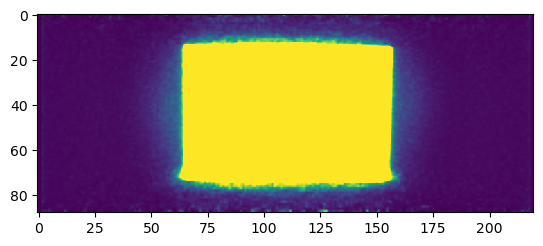

In [42]:
plt.imshow(inpImage[:,120,:],vmax=inpImage.max()*1e-2)

# Reconstruction

## Acquisition model definition

In [43]:
acq_model = STIR.AcquisitionModelUsingParallelproj()
ss_model = STIR.AcquisitionModelUsingParallelproj()
template = STIR.AcquisitionData(os.path.join(data_path, 'prompts.hs'))
multCorr = STIR.AcquisitionData(os.path.join(data_path,'mult_factors.hs'))
addCorr = STIR.AcquisitionData(os.path.join(data_path,'additive_term.hs'))

rMax = addCorr.max()*1e-6
addCorr +=rMax
acq_model.set_acquisition_sensitivity(STIR.AcquisitionSensitivityModel(multCorr))
#
acq_model.set_additive_term(addCorr)
acq_model.set_up(template, image)
#


INFO: Tbin -16: -354.252 - -332.782 mm (-2363.31 - -2220.08 ps) = 21.4698

INFO: Tbin -15: -332.782 - -311.312 mm (-2220.08 - -2076.85 ps) = 21.4698

INFO: Tbin -14: -311.312 - -289.843 mm (-2076.85 - -1933.62 ps) = 21.4698

INFO: Tbin -13: -289.843 - -268.373 mm (-1933.62 - -1790.39 ps) = 21.4698

INFO: Tbin -12: -268.373 - -246.903 mm (-1790.39 - -1647.16 ps) = 21.4698

INFO: Tbin -11: -246.903 - -225.433 mm (-1647.16 - -1503.93 ps) = 21.4698

INFO: Tbin -10: -225.433 - -203.963 mm (-1503.93 - -1360.7 ps) = 21.4698

INFO: Tbin -9: -203.963 - -182.493 mm (-1360.7 - -1217.47 ps) = 21.4698

INFO: Tbin -8: -182.493 - -161.024 mm (-1217.47 - -1074.23 ps) = 21.4698

INFO: Tbin -7: -161.024 - -139.554 mm (-1074.23 - -931.003 ps) = 21.4698

INFO: Tbin -6: -139.554 - -118.084 mm (-931.003 - -787.772 ps) = 21.4698

INFO: Tbin -5: -118.084 - -96.6142 mm (-787.772 - -644.54 ps) = 21.4698

INFO: Tbin -4: -96.6142 - -75.1444 mm (-644.54 - -501.309 ps) = 21.4698

INFO: Tbin -3: -75.1444 - -53.6745

 mm (-501.309 - -358.078 ps) = 21.4698

INFO: Tbin -2: -53.6745 - -32.2047 mm (-358.078 - -214.847 ps) = 21.4698

INFO: Tbin -1: -32.2047 - -10.7349 mm (-214.847 - -71.6156 ps) = 21.4698

INFO: Tbin 0: -10.7349 - 10.7349 mm (-71.6156 - 71.6156 ps) = 21.4698

INFO: Tbin 1: 10.7349 - 32.2047 mm (71.6156 - 214.847 ps) = 21.4698

INFO: Tbin 2: 32.2047 - 53.6745 mm (214.847 - 358.078 ps) = 21.4698

INFO: Tbin 3: 53.6745 - 75.1444 mm (358.078 - 501.309 ps) = 21.4698

INFO: Tbin 4: 75.1444 - 96.6142 mm (501.309 - 644.54 ps) = 21.4698

INFO: Tbin 5: 96.6142 - 118.084 mm (644.54 - 787.772 ps) = 21.4698

INFO: Tbin 6: 118.084 - 139.554 mm (787.772 - 931.003 ps) = 21.4698

INFO: Tbin 7: 139.554 - 161.024 mm (931.003 - 1074.23 ps) = 21.4698

INFO: Tbin 8: 161.024 - 182.493 mm (1074.23 - 1217.47 ps) = 21.4698

INFO: Tbin 9: 182.493 - 203.963 mm (1217.47 - 1360.7 ps) = 21.4698

INFO: Tbin 10: 203.963 - 225.433 mm (1360.7 - 1503.93 ps) = 21.4698

INFO: Tbin 11: 225.433 - 246.903 mm (1503.93 - 1647.16

In [44]:
ss_model = acq_model.get_linear_acquisition_model()

In [45]:
# templRed = STIR.AcquisitionData(os.path.join(data_path, 'prompts.hs'),max_ring_diff=1,view_mash_factor=2)
# acq_model_red = STIR.AcquisitionModelUsingParallelproj()
# acq_model_red.set_up(templRed,image)

# PGA

## Compute diagonal preconditioner as the diagonal of the hessian 

(BP(attenuation^2))

In [46]:


fwdProj = acq_model.forward(image)
fp1 = ss_model.forward(image.get_uniform_copy(1))
# tFP += addCorr
# tFP *= multCorr
# rMax = addCorr.max()* 1e-6
# tFP += rMax # add a very small number to avoid dividing by 0
#myK = acq_model.backward((template/tFP)*(fp1/tFP))
myK = acq_model.backward(fp1/fwdProj)
myKsqroot = np.sqrt(myK.as_array()+1e-10)
#tFP = []
fp1 = []

In [15]:
idx=5

In [16]:
idx

5

In [16]:

myK_4p = (myK.power(0.5) + 1)

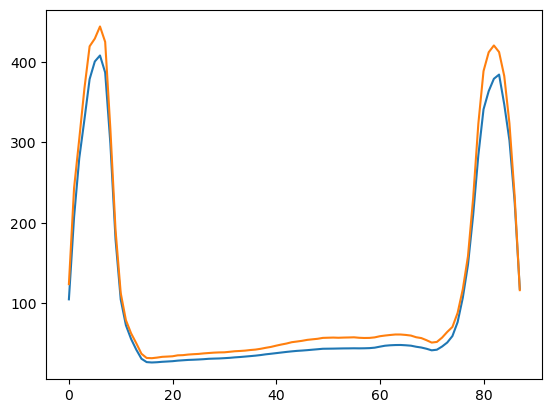

In [17]:
plt.plot(myK_4p.as_array()[:,100,100]/3)
plt.plot(kappa.as_array()[:,100,100])
#plt.ylim(0,500)

In [818]:
stir_prior.set_kappa(myK_4p)
stir_prior.set_up(image)

In [ ]:
plt.imshow(myK.as_array()[20,:,:])

### prior hessian

In [47]:
def rdp_hess (inpImm_,kappa_,eps_,pixS_):
    rdpH_ = np.zeros_like(inpImm_)
    for xs in range(-1,2):
        for ys in range (-1,2):
            for zs in range(-1,2):
                if (xs == 0) and (ys==0) and (zs==0): 
                    print('continuing')
                    continue
                shiftImm_ = np.roll(inpImm_,(zs,xs,ys),axis=(0,1,2))
                sk_ = np.roll(kappa_,(zs,xs,ys),axis=(0,1,2))
                if zs==-1:
                    shiftImm_[-1,:,:]= inpImm_[-1,:,:]
                if zs==1:
                    shiftImm_[0,:,:] = inpImm_[0,:,:]

                tempW = pixS_[1]*kappa_*sk_ / np.sqrt((zs*pixS_[0])**2+(xs*pixS_[1])**2+(ys*pixS_[2])**2)             
                rdpH_ += tempW*(16*(inpImm_**1)) /((inpImm_)+ (shiftImm_) + 2*np.abs(inpImm_-shiftImm_ )+eps_)** 3 
    return rdpH_

In [836]:
pHi = 1/700*rdp_hess(inpImage,myK_4p.as_array(),penEps,image.dimensions())

continuing


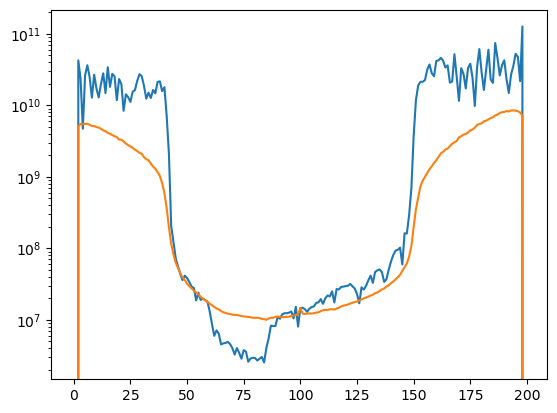

In [844]:
plt.plot(pHi[72,:,100])
plt.plot(myK.as_array()[72,:,100]*200)
plt.yscale('log')

In [433]:
myK.fill(myK.as_array()+pHi)
myKsqroot = np.sqrt(myK.as_array()+1e-10)

Text(0.5, 1.0, 'Profile at pixel 100,100')

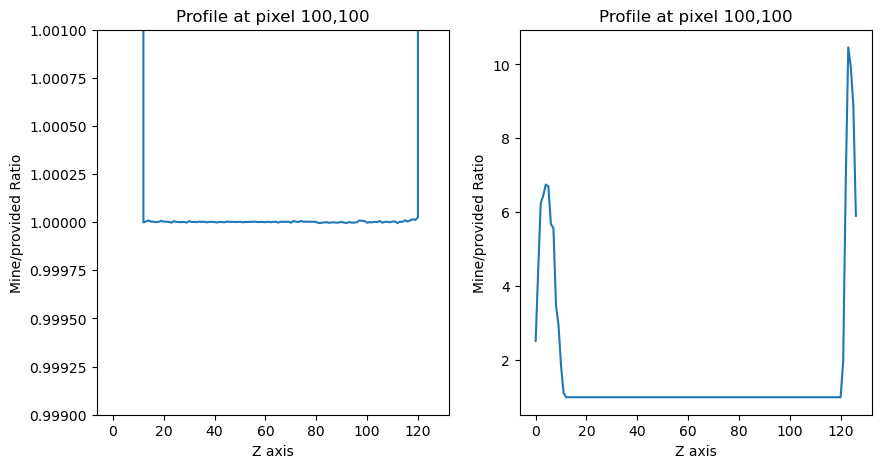

In [609]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(((myK/(kappa.power(2))).as_array())[:,100,100])
#plt.plot((myK.as_array())[:,100,100])
#plt.yscale('log')
plt.ylim(1-.001,1.001)
plt.xlabel('Z axis')
plt.ylabel('Mine/provided Ratio')
plt.title('Profile at pixel 100,100')
plt.subplot(122)
plt.plot(((myK/(kappa.power(2))).as_array())[:,100,100])
plt.xlabel('Z axis')
plt.ylabel('Mine/provided Ratio')
plt.title('Profile at pixel 100,100')
#plt.xlim(0,10)

In [633]:
myK +=.1

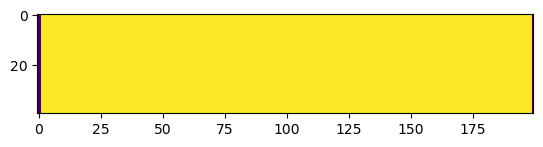

In [632]:
plt.imshow(myK.as_array()[:40,100,:],vmax=1)


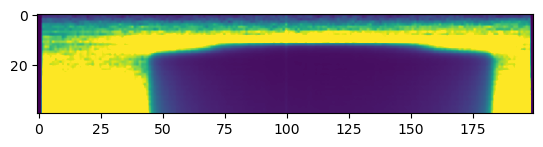

In [530]:
plt.imshow(kappa.as_array()[:40,100,:]**2,vmax=1e6)
#plt.colorbar()

In [511]:
fpOnes = ss_model.forward(image.get_uniform_copy(1))

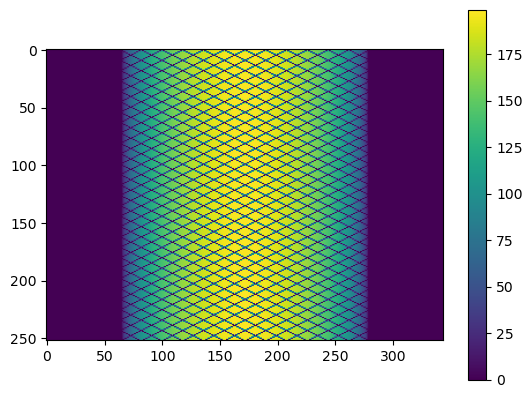

In [528]:
plt.imshow((fpOnes/(multCorr + 1e-10)).as_array()[0,100,:,:])
plt.colorbar()

In [500]:
help (STIR.PoissonLogLikelihoodWithLinearModelForMean.multiply_with_Hessian)

Help on function multiply_with_Hessian in module sirf.STIR:

multiply_with_Hessian(self, current_estimate, input_, subset=-1, out=None)
    Computes the multiplication of the Hessian at current_estimate with a vector.



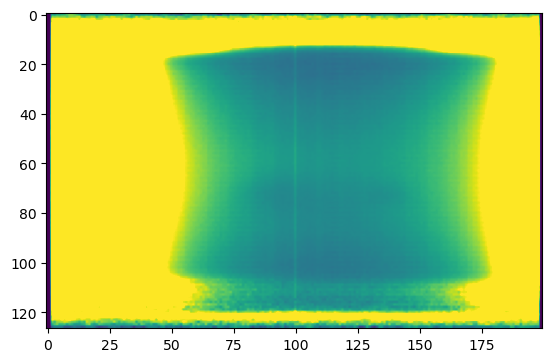

In [254]:
plt.imshow(kappa.as_array() [:,100,:],vmax=500)

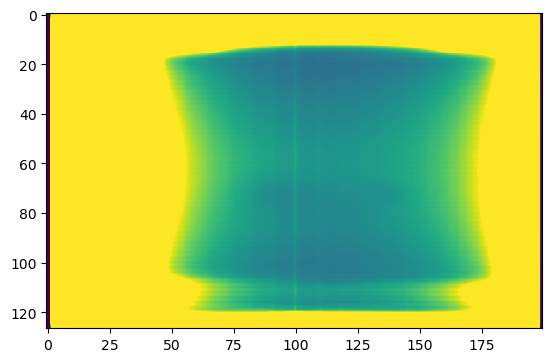

In [255]:
plt.imshow(myK_4p.as_array()[:,100,:],vmax=500)
#plt.colorbar()

### compute masks

In [48]:
mask = kappa.as_array()<1
print(mask.dtype)
mask = ndi.binary_dilation(mask)
print(mask.dtype)
mask = 1 - mask
print(mask.dtype)
#maskImm = STIR.ImageData(
maskS = image.get_uniform_copy(0)
maskS.fill(mask)

bool
bool
int64


In [49]:
mask = mask.astype(bool)

In [97]:
print(template.get_info())

Modality: PT
Calibration Factor: -1.000000000000
Radionuclide Parameters:
Modality: PT
Radionuclide: ^18^Fluorine
Energy 511.000000000000
Half-life: 6584.040039062500
Branching ratio: 0.968599975109

Patient position: FFS
Scan start time: 0.0
Time frame start - end (duration), all in secs: 0.0 - 1200.0 (1200.0)
number of energy windows:=1
energy window lower level[1] := 435.0
energy window upper level[1] := 585.0
ProjDataInfoCylindricalNoArcCorr := 
Scanner parameters:=
  Scanner type := Siemens Vision 600
  Number of rings                          := 80
  Number of detectors per ring             := 798
  Inner ring diameter (cm)                 := 82
  Average depth of interaction (cm)        := 0.7
  Distance between rings (cm)              := 0.329114
  Default bin size (cm)                    := 0.16
  View offset (degrees)                    := 0
  Maximum number of non-arc-corrected bins := 520
  Default number of arc-corrected bins     := 520
  Energy resolution         := 0
  R

In [50]:
myKArr = myKsqroot**2
thr = np.percentile(myKArr[mask],10)*10
maskSDir = inpImage>(inpImage.max()*1e-2)
maskSDir[0,:,:]=0
maskSDir[-1,:,:]=0

The border line often has numerical instability, let alone the area outside the circle which is NaN by definition. Define a mask

In [51]:
def makeFFT_2D_filter (imShape_,tRes_=400,pixS_=2):
    d_ = .65
    order = np.power(2,np.ceil(np.log2(imShape_[1]))).astype(np.uint32)
   # freqN = np.power(2,np.ceil(np.log2(imShape_[1]//2))).astype(np.uint32)
    print (order)
    freqN = order//2
    nFreq = np.arange(0,freqN +1)
    filtImpResp = np.zeros((len(nFreq),))
    filtImpResp[0]=1/4
    filtImpResp[1::2]=-1/((np.pi*nFreq[1::2])**2)

    #TOF part
    xV_ = nFreq*pixS_
    tRes_ = tRes_*0.15/2.35 # 300 mm /ns --> .3 mm/ps --> /2 because 2 photons 
    tKern_ = np.exp(-(xV_**2/(4*tRes_**2)))
    filtImpResp *=tKern_
    
    filtImpResp = np.concatenate([filtImpResp,filtImpResp[-2:0:-1]])
    ftFilt = 2 * np.real(np.fft.fft(filtImpResp)) # check! when implemented correctly the imag part is zero within numerical precision
    ftFilt = ftFilt[:(freqN+1)]
    
    #fMax = freqN
    fV = 2*np.pi*(np.arange(1,freqN+1))/imShape_[1]
    ftFilt[1:] *= (np.sin(fV/(2*d_)) / (fV/(2*d_)))
    ftFilt[ftFilt<0]=0
    
    xf = np.arange(0,imShape_[1]//2+1).reshape((1,imShape_[1]//2+1))
    yf = xf.transpose()
    freqR = np.sqrt(xf**2+yf**2)
    interpF = np.interp(freqR,nFreq,ftFilt,right=0)
    interpF = np.concatenate([interpF,interpF[-2:0:-1,:]],axis=0)
    interpF = np.concatenate([interpF,interpF[:,-2:0:-1]],axis=1)
    interpF = interpF.reshape((1,)+imShape_[1:])
    return interpF
    
    #invFFilt = np.fft.ifft(np.real(ftFilt)) 

#filtImpResp = 


In [22]:
image.spacing[1]

3.3

In [75]:
myFilt = makeFFT_2D_filter(inpImage.shape,tRes_=100,pixS_=image.spacing[1])

256


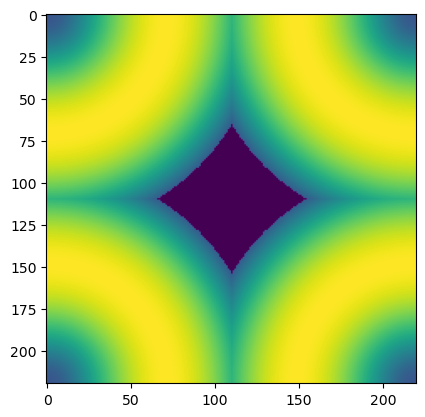

In [76]:
plt.imshow(myFilt[0,:,:])

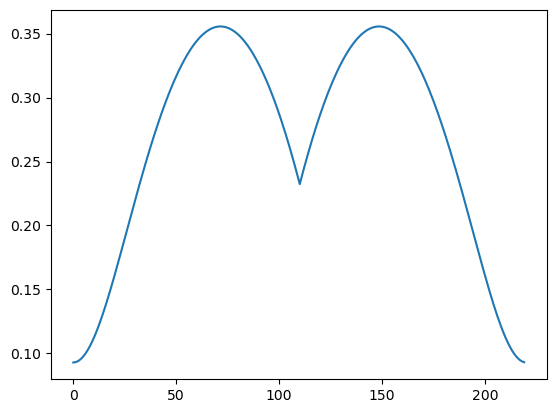

In [77]:
plt.plot(myFilt[0,0,:])

## Actual recon loop

Recon with preconditioned, maybe conjugate gradient descent

In [26]:
# UNCOMMENT and run to "restart" from the clean image
import time
ts = time.time()
image.fill(inpImage)
print(time.time()-ts)

0.13629865646362305


In [78]:
import scipy.ndimage as ndi

image.fill(ndi.gaussian_filter(inpImage,.75))

In [64]:
acq_model.forward(image,out=fwdProj)

In [30]:
addCorrArray = (addCorr*multCorr).as_array()
addCorrArray += 1e-6*addCorrArray.max()

In [58]:
addCorr.dimensions()

(33, 815, 50, 520)

In [79]:
nIt = 15

recItV_P_F3_M = np.zeros((nIt+1,) + inpImage.shape)
recItV_P_F3_M[0,:,:,:] = image.as_array()
betaPen =  1/700
penEps = 1e-3*inpImage.max()

fPsDir = template.get_uniform_copy(0)
gradI = image.get_uniform_copy(0)
sDir = image.get_uniform_copy(0)


for itIdx in range(nIt):

    gradSino = template/fwdProj - 1
    acq_model.backward(gradSino,out=gradI) #*multCorr)
    pGrad = stir_prior.gradient(image)
    grad = gradI - pGrad
    # sDir = grad*maskS / (myK + 1e-10) # avoid dividing by 0. BTW, myK is be definition higher than 1
#    break
    #gradArr = gradI.as_array() - betaPen*rdp_grad(image.as_array(),kappa.as_array(),penEps,image.voxel_sizes())
    gradArr = grad.as_array()
    gradArr /= myKsqroot
    gradArr = np.fft.fft2(gradArr,axes=(1,2))
    gradArr *= myFilt
    gradArr = np.real(np.fft.ifft2(gradArr,axes=(1,2)))
    gradArr = ndi.gaussian_filter(gradArr,(0.5,0,0))
    gradArr /= myKsqroot
    sDir.fill(gradArr*mask)
  # #  

    # Uncomment to conver to conjugate 
    
    # if itIdx>0:
    #     beta = (grad-gradP).dot(sDir)/gradP.dot(prevSDir)
    #     # if (ss<0) | (np.abs(ssNum/(2*betaPen*penSSNum)+1)<0.01):    
    #     #     beta = 0
    #     sDir += beta * prevSDir 
    # prevSDir = sDir.clone()
    # gradP = grad.clone()   

    ss_model.forward(sDir,out=fPsDir) #*multCorr

    # Tomographic step size
    
    ssNum = sDir.dot(gradI)
#  0  ssDen = fPsDir.dot((fPsDir/fwdProj)*(template/fwdProj))
    ssDen = fPsDir.dot((fPsDir/fwdProj))
#    ssDen = fPsDir.dot((fPsDir/sinDenoStir))
    ssTomo = ssNum/ssDen
    #ss = ssTomo
    # penalty step size
    penSSNum, penSSDen = rdp_step_size(image.as_array(),sDir.as_array(),kappa.as_array()*maskSDir,penEps,image.voxel_sizes())
    ss = (ssNum+2*betaPen*penSSNum)/(ssDen+2*betaPen*penSSDen)
    print ('num: {:.1e} den: {:.1e} penNum {:.1e} penDen {:.1e}'.format(ssNum,ssDen,2*betaPen*penSSNum,2*betaPen*penSSDen))
#    break
    
    # update image and sinogram
    prevImm = image.clone()
    image += ss*sDir
  #  fwdProj += ss*fPsDir
 #   print(ss)

# UNCOMMENT to update sinogram in each iteration
    

    imArr = image.as_array()
    imArr[imArr<0]=0
    imArr[np.isnan(imArr)] = 0
    image.fill(imArr)
    acq_model.forward(image,out=fwdProj)
    # prevSDir = (image - prevImm)/ss

   #     prevSDir = prevSDir.get_uniform_copy(0)

    # sinDeno = fwdProj.as_array()
    # sinDeno[sinDeno<addCorrArray] = addCorrArray[sinDeno<addCorrArray]
    # sinDenoStir.fill(sinDeno)
    # ts = time.time()
    # fwdProj += addCorr 
    # t1 = time.time()
    # fwdProj *= multCorr 
    # t2 = time.time()
   # if (itIdx%20)==0:
   #  print(itIdx)
    

  #  fwdProj+= ss/ssDen*fPsDir
    recItV_P_F3_M[itIdx+1,:,:,:] = imArr #image.as_array()
    

num: 2.2e+05 den: 1.8e+04 penNum -9.1e+01 penDen 1.0e+01
num: 1.5e+05 den: 9.3e+03 penNum -3.9e+03 penDen 2.0e+02
num: 4.4e+04 den: 3.3e+03 penNum 3.5e+02 penDen 6.2e+02
num: 4.4e+04 den: 3.3e+03 penNum -5.9e+02 penDen 1.8e+02
9481

INFO: current proj max: 0.005738

INFO: current proj max: 2.699517

INFO: current proj max: 0.006078

INFO: current proj max: 2.700096

INFO: current proj max: 0.005565

INFO: current proj max: 2.700082

INFO: current proj max: 0.005956

INFO: current proj max: 2.700609

INFO: current proj max: 0.005648

INFO: current proj max: 2.700553

INFO: current proj max: 0.006090

INFO: current proj max: 2.701046

INFO: current proj max: 0.005567

INFO: current proj max: 2.700955

INFO: current proj max: 0.005883

INFO: current proj max: 2.701410

INFO: current proj max: 0.005610

INFO: current proj max: 2.701295

INFO: current proj max: 0.006075

INFO: current proj max: 2.701723

INFO: current proj max: 0.005606

INFO: current proj max: 2.701583

INFO: current proj 

In [80]:
ss


10.737363798930522

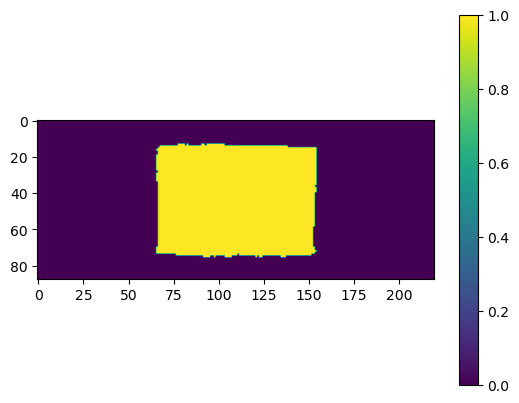

In [67]:
plt.imshow(maskSDir[:,125,:])
plt.colorbar()

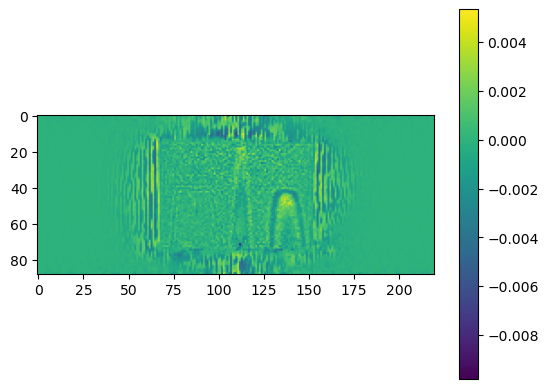

In [81]:
#mask3 = (inpImage>(penEps))
plt.imshow(ss*sDir.as_array()[:,125,:]) #,vmax=0.152)
plt.colorbar()
#plt.contour(mask3[:,100,:],0,colors='r')

In [82]:
np.save ('tof_thorax_plain.npy',recItV_plain)

In [62]:
ImmT = STIR.ImageData('/workdir/refs/vision_Thorax/reference_image.hv')

In [45]:
ts = time.time()
iR = image.as_array()
print (ts-time.time())

-0.13063955307006836


(70.0, 150.0)

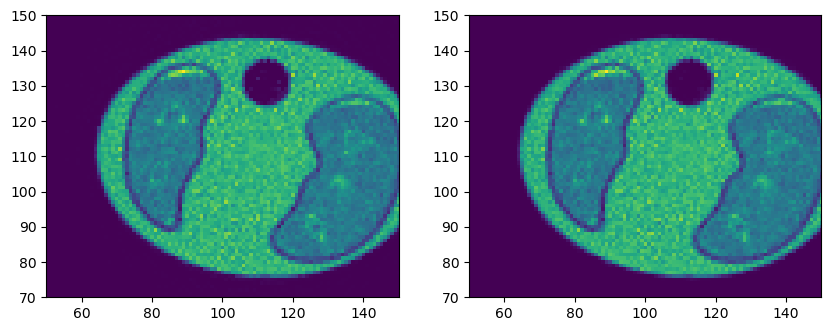

In [45]:
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(recItV_C_F_M[-1,50,:,:],vmax=.522)
plt.xlim(50,150)
plt.ylim(70,150)
plt.subplot(122)
plt.imshow(recImmCG[50,:,:],vmax=.522)
plt.xlim(50,150)
plt.ylim(70,150)

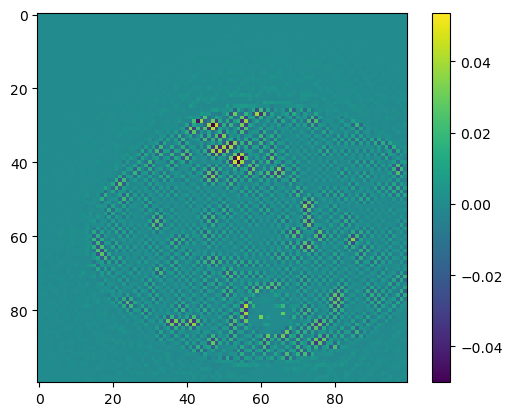

In [46]:
#mask3 = (inpImage>(penEps))
#plt.imshow((image.as_array()-recImmCG)[:,125,:],vmax=.02,vmin=-.02) #,vmax=0.152)
plt.imshow((image.as_array()-recImmCG)[50,50:150,50:150])
plt.colorbar()
#plt.contour(mask3[:,100,:],0,colors='r')

### Plot some images

In [4]:
recImmCG = STIR.ImageData('/workdir/refs/vision_Thorax/reference_image.hv').as_array()

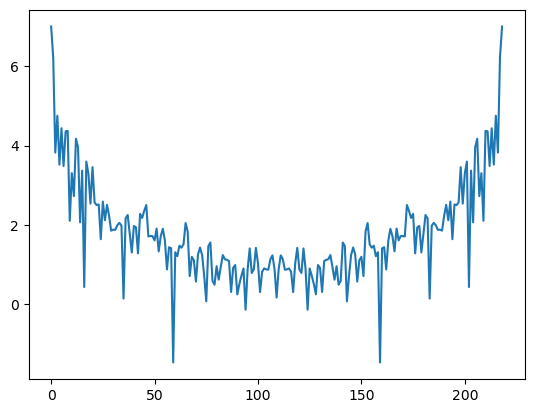

In [27]:
plt.plot(np.log(np.abs(np.fft.fft2(recImmCG[45,:,:]))[0,1:]))

In [48]:
np.save('visTOF_Conj_filt_NOmask.npy',recItV_C_F_M)

In [28]:
recItV_C_M = np.load('visTOF_Conj_NOf_NOmask.npy')

In [29]:
recItV_P_F = np.load('visTOF_Plain_filt_mask.npy')

In [31]:
recItV_f2 = np.load('visTOF_conjCorr_filt_mask.npy')

Text(0, 0.5, 'Difference norm')

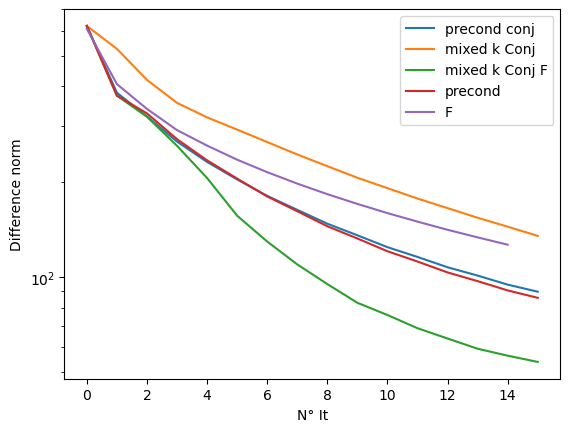

In [83]:
dV = np.sum(np.sum(np.sum((recItV_P_F[:16,:,:,:]-np.expand_dims(recImmCG,axis=0))**2,axis=-1),axis=-1),axis=-1)
plt.plot(dV)
dV = np.sum(np.sum(np.sum((recItV_C_M[:16,:,:,:]-np.expand_dims(recImmCG,axis=0))**2,axis=-1),axis=-1),axis=-1)
plt.plot(dV)
# dV = np.sum(np.sum(np.sum((recItV_f2[:,:,:,:]-np.expand_dims(recImmCG,axis=0))**2,axis=-1),axis=-1),axis=-1)
# plt.plot(dV)

dV = np.sum(np.sum(np.sum((recItV_C_F2_M[:16,:,:,:]-np.expand_dims(recImmCG,axis=0))**2,axis=-1),axis=-1),axis=-1)
plt.plot(dV)


dV = np.sum(np.sum(np.sum((recItV_P_F2_M[:16,:,:,:]-np.expand_dims(recImmCG,axis=0))**2,axis=-1),axis=-1),axis=-1)
plt.plot(dV)

dV = np.sum(np.sum(np.sum((recItV_P_F3_M[1:16,:,:,:]-np.expand_dims(recImmCG,axis=0))**2,axis=-1),axis=-1),axis=-1)
plt.plot(dV)


# dV = np.sum(np.sum(np.sum((recItV_P_Fok_M[:,:,:,:]-np.expand_dims(recImmCG,axis=0))**2,axis=-1),axis=-1),axis=-1)
# plt.plot(dV)

plt.yscale('log')
plt.legend(['precond conj','mixed k Conj','mixed k Conj F','precond','F','F higher','F2_F','F2_Fs','F3_F3'])
plt.xlabel('N° It')
plt.ylabel('Difference norm')
#plt.xlim((0,16))
#plt.ylim(20,9e2)


In [50]:
np.save('recIt_diagPrecond.npy',recItV)

In [51]:
np.save('refImm.npy',recImmCG)

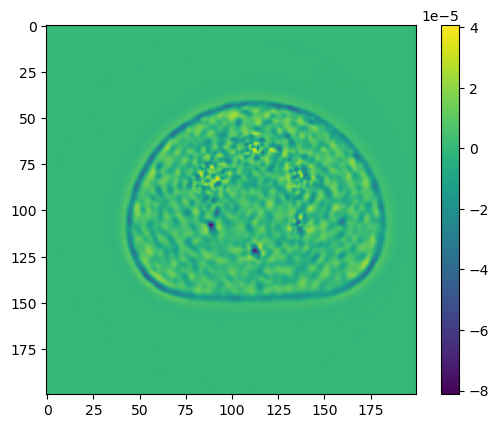

In [176]:
plt.imshow(ss*sDir.as_array()[72,:,:])
plt.colorbar()

/tmp/ipykernel_50445/1781100817.py:2: RuntimeWarning: invalid value encountered in divide
  plt.imshow(gradI.as_array()[72,:,:]/myK.as_array()[72,:,:],vmin=-.1,vmax=.1)
/tmp/ipykernel_50445/1781100817.py:5: RuntimeWarning: invalid value encountered in divide
  plt.imshow(gradP.as_array()[72,:,:]/myK.as_array()[72,:,:],vmin=-.1,vmax=.1)


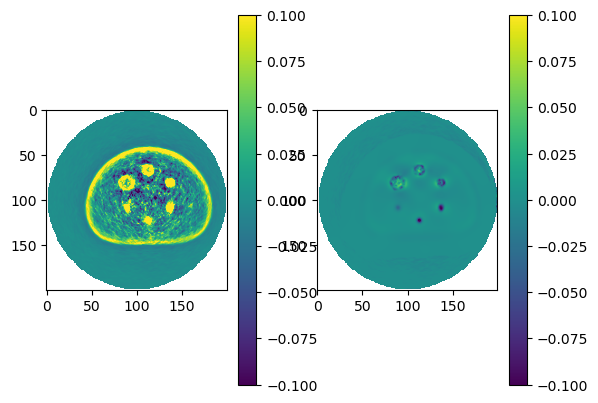

In [53]:
plt.subplot(121)
plt.imshow(gradI.as_array()[72,:,:]/myK.as_array()[72,:,:],vmin=-.1,vmax=.1)
plt.colorbar()
plt.subplot(122)
plt.imshow(gradP.as_array()[72,:,:]/myK.as_array()[72,:,:],vmin=-.1,vmax=.1)
plt.colorbar()

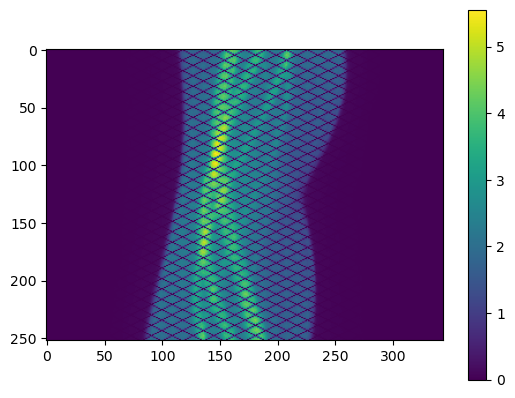

In [666]:
slIdx +=1
plt.imshow(tFP.as_array()[0,slIdx,:,:])
plt.colorbar()

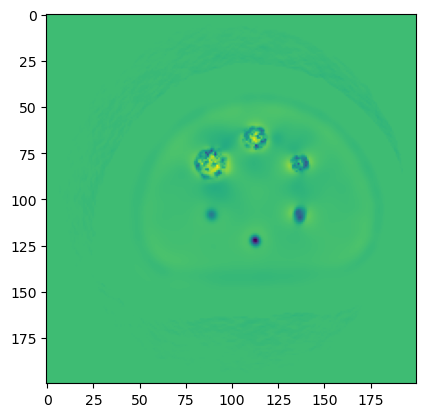

In [258]:
plt.imshow(sDir.as_array()[72,:,:]) #,vmax=400)

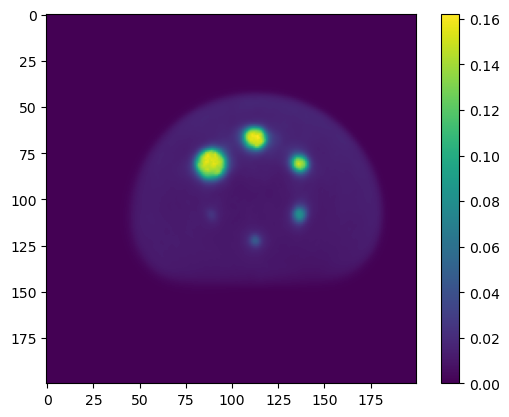

In [260]:
plt.imshow(image.as_array()[72,:,:]) #,vmax=.)
plt.colorbar()

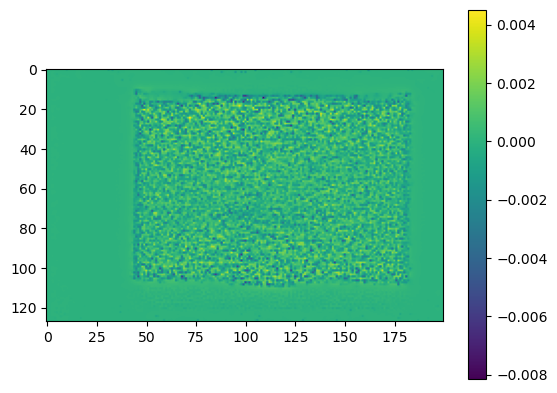

In [676]:
plt.imshow(recItV[18,:,100,:]-recItV[0,:,100,:])
plt.colorbar()

In [479]:
ss/ssDen

0.0

In [261]:
dV = np.sum(np.sum(np.sum(recItV-np.expand_dims(recItV[-1,:,:,:,],axis=0),axis=-1),axis=-1),axis=-1)**2
plt.plot(dV)

NameError: name 'recItV' is not defined

In [27]:
import scipy.ndimage as ndi

/tmp/ipykernel_11022/2359744373.py:1: RuntimeWarning: invalid value encountered in divide
  plt.imshow(sDir.as_array()[:,100,:]/kappa.as_array()[:,100,:],vmin=-0.00003,vmax=.00003)


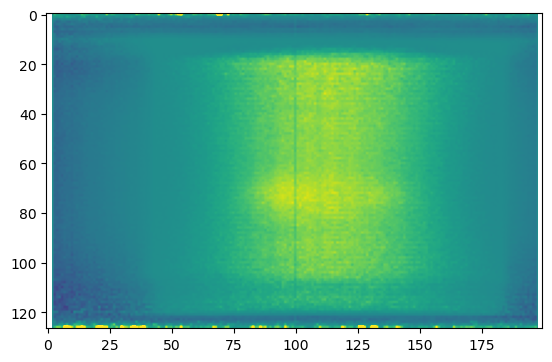

In [457]:
plt.imshow(sDir.as_array()[:,100,:]/kappa.as_array()[:,100,:],vmin=-0.00003,vmax=.00003)
#plt.colorbar()

/tmp/ipykernel_11022/2999593000.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(grad.as_array()[72,:,:]/kappa.as_array()[72,:,:]**2)
/tmp/ipykernel_11022/2999593000.py:1: RuntimeWarning: invalid value encountered in divide
  plt.imshow(grad.as_array()[72,:,:]/kappa.as_array()[72,:,:]**2)


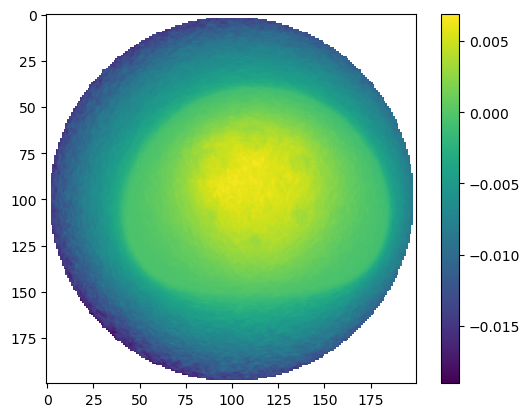

In [415]:

plt.imshow(grad.as_array()[72,:,:]/kappa.as_array()[72,:,:]**2)
plt.colorbar()

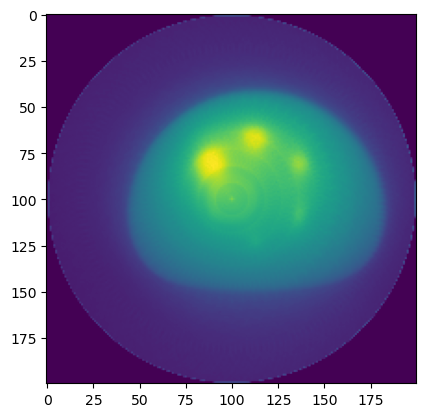

In [331]:
plt.imshow(bkwP.as_array()[72,:,:]/(kappa.as_array()[72,:,:]))